In [1]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import keras

C:\Users\Parker\Miniconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Loading and formatting the data
---

In [2]:
# Setting cute at index 1.  This will slightly simplify the final rating process
# since we can just average out the values.
CATEGORIES = ["ugly", "cute"]
DIRECTORY = "./Data/Images"

In [5]:
def transform_image(img):
    """
    Adds black padding around an image to make it square,
    then resizes to 96x96, then returns.
    """
    
    # I don't want to stretch the image, so I'll add padding to make it
    # square based on the largest dimension.
    dims = img.shape[:2]
    argmax_dim = np.argmax(dims)
    max_dim = dims[argmax_dim]

    # Shape is height, width, depth.  So, if argmax is 0 then height is max
    # and I should pad the left and right.  Opposite respectively for width.
    padding_amount = abs(np.diff(dims).item()) // 2

    padding_options = {
        0: {'top': 0, 'bottom': 0, 'left': padding_amount, 'right': padding_amount},
        1: {'top': padding_amount, 'bottom': padding_amount, 'left': 0, 'right': 0}
    }

    padding = padding_options[argmax_dim]

    # cv2.copyMakeBorder(src, top, bottom, left, right, method)
    padded = cv2.copyMakeBorder(img, **padding, borderType=cv2.BORDER_ISOLATED)

    resized = cv2.resize(padded, (96, 96))

    return resized

In [6]:
def create_dataset():
    dataset = []
    
    for category in CATEGORIES:
        path = os.path.join(DIRECTORY, category)

        # 0 is ugly, 1 is cute
        label = CATEGORIES.index(category)

        for filename in os.listdir(path):
            img = cv2.imread(os.path.join(path, filename))

            transformed = transform_image(img)

            dataset.append((transformed, label))
            
    return dataset

In [8]:
dataset = create_dataset()
len(dataset)

5070

In [9]:
# Shuffle the dataset
random.shuffle(dataset)

In [10]:
X = []
y = []

for data, label in dataset:
    X.append(data)
    y.append(label)
    
X = np.array(X).reshape(-1, 96, 96, 3) # 3 channels, rgb

In [11]:
import pickle

with open("X.pickle", 'wb') as pickle_out:
    pickle.dump(X, pickle_out)

with open("y.pickle", 'wb') as pickle_out:
    pickle.dump(y, pickle_out)

# Commence training
---

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [15]:
with open("X.pickle", 'rb') as pickle_in:
    X = pickle.load(pickle_in)
    
with open("y.pickle", 'rb') as pickle_in:
    y = pickle.load(pickle_in)

In [17]:
X = X / 255

In [20]:
X.shape

(5070, 96, 96, 3)

In [72]:
model = Sequential()

# Conv2D(filters, kernel_size)
model.add(Conv2D(64, kernel_size=3, input_shape=X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=3, input_shape=X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=64))

model.add(Dense(units=1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X, y, batch_size=128, validation_split=0.2, epochs=15)

Train on 4056 samples, validate on 1014 samples
Epoch 1/15
4056/4056 [==============================] - 6s 2ms/step - loss: 0.9448 - acc: 0.5350 - val_loss: 0.6786 - val_acc: 0.6095
Epoch 2/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.6710 - acc: 0.5907 - val_loss: 0.6342 - val_acc: 0.6420
Epoch 3/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.6410 - acc: 0.6277 - val_loss: 0.6225 - val_acc: 0.6578
Epoch 4/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.6252 - acc: 0.6526 - val_loss: 0.6458 - val_acc: 0.6085
Epoch 5/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.6025 - acc: 0.6709 - val_loss: 0.6346 - val_acc: 0.6588
Epoch 6/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.5920 - acc: 0.6866 - val_loss: 0.6681 - val_acc: 0.6223
Epoch 7/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.5578 - acc: 0.7187 - val_loss: 0.6269 - val_acc: 0.6420
Epoch 8/15
405

<font color="red">
# TODO: check why validation accuracy is always zero!

# A small, quick, manual, test
---

In [48]:
%matplotlib inline

In [79]:
path = "./Test"
for filename in os.listdir(path):
    img = cv2.imread(os.path.join(path, filename))
    transformed = transform_image(img)
    
    to_predict = transformed.reshape(-1, 96, 96, 3)
    
    prediction = model.predict_classes(to_predict)
    pred = "cute" if prediction else "ugly"
    print("Name: {}\nPrediction: {}".format(filename, prediction))

Name: cute0.jpg
Prediction: [[1]]
Name: cute1.jpg
Prediction: [[1]]
Name: cute2.jpg
Prediction: [[1]]
Name: ugly0.jpg
Prediction: [[0]]
Name: ugly1.jpg
Prediction: [[1]]
Name: ugly2.jpg
Prediction: [[1]]


<font color="red">
### I'll need to make a test set to see what's going on here.

In [76]:
model.predict_classes(X[2].reshape(-1, 96, 96, 3))

array([[0]])

In [77]:
y[2]

0

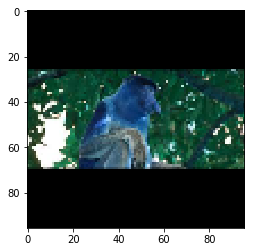

In [78]:
plt.imshow(X[2])